## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [ ]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [ ]:
x = torch.randn(5, 8)
y = torch.randn(5, 8) 

In [ ]:
x

tensor([[ 0.0828,  0.9989,  0.1174,  1.5149, -0.1539,  0.4318, -0.3450, -0.4395],
        [-0.6879,  1.0747,  0.2794,  0.2389,  0.7078,  0.7931, -0.0715,  0.2052],
        [-2.1421, -1.7921, -0.7062, -0.5473, -1.1125, -0.1794,  2.0125, -1.1001],
        [-0.3917, -0.5913,  1.0519,  1.6025, -1.1475, -0.9893, -1.2429,  1.7894],
        [ 0.0251, -0.4350, -0.1958, -0.1053, -0.9879,  2.0359, -0.9550,  0.9100]])

In [ ]:
y

tensor([[ 1.0148, -0.2724, -0.9344,  0.6048,  0.7325,  0.0723, -1.7792,  1.5129],
        [-0.0214, -0.0074, -0.2406,  0.5330,  0.5975,  0.9591,  0.4426,  1.0648],
        [-0.2261, -0.4445,  0.1541,  0.2419, -1.3133, -1.4601,  1.4497,  1.1945],
        [-0.3951,  0.0690, -1.2503, -0.3686,  0.9951, -1.0461,  0.2595, -1.0127],
        [ 0.3829, -0.4153,  0.4172, -0.3975, -0.6990, -0.3849, -1.2993, -0.1341]])

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [ ]:
z = torch.empty((5, 5))
torch.matmul(x, y.transpose(0, 1), out=z)
z

tensor([[ 0.4858,  0.4714, -1.5315, -0.9183, -0.4877],
        [-0.0940,  1.4373, -2.1674, -0.4431, -1.4227],
        [-7.4295, -1.1800,  4.3661,  2.5244, -1.7736],
        [ 3.7562,  0.3347,  4.1884, -4.0337,  2.4555],
        [ 2.7626,  1.9024, -1.8408, -4.0384,  1.1762]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [ ]:
def relu_forward(x):
    return torch.maximum(x, torch.zeros(x.shape))

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def elu_forward(x):
    return torch.where(x < 0, torch.expm1(x), x)

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def lrelu_forward(x, alpha):
    return torch.where(x < 0, x * alpha, x)

assert torch.allclose(F.leaky_relu(x, 0.01), lrelu_forward(x, 0.01), 1e-4)

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def mish(x):
    return x * torch.tanh(torch.log(1 + torch.exp(x)))

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def swish(x):
    return x * torch.sigmoid(x) 

swish(torch.tensor([1, 1, 1], dtype=torch.float32))

tensor([0.7311, 0.7311, 0.7311])

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [ ]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [ ]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
      defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
      super().__init__(params, defaults)

    def _group_step(self, group):
      # One group contains information about values passed in init
      # and model parameters to update
      lr = group['lr']
      eps = group['eps']
      beta_1 = group['beta_1']
      beta_2 = group['beta_2']      
      for param in filter(lambda x: x.grad is not None, group['params']):
        g = param.grad
        self._init_adam_buffer(param)
        buffer = self._get_adam_buffer(param)
        m, v, t = buffer['m'], buffer['v'], buffer['t'] + 1
        m = beta_1 * m + (1 - beta_1) * g
        v = beta_2 * v + (1 - beta_2) * (g ** 2)
        m_hat = m / (1 - beta_1 ** t)
        v_hat = v / (1 - beta_2 ** t)
        div = m_hat / torch.sqrt(v_hat + eps)
        # Inplace update of params multiplied by -lr
        param.add_(div, alpha=-lr)
        buffer['m'], buffer['v'], buffer['t'] = m, v, t

    def _get_adam_buffer(self, d_param):      
      """
      Get accumulated gradients for Adam.

      Parameters
      ----------
      param : `torch.Tensor`, required
          Model parameter to get accumulated gradeints for Adam.

      Returns
      -------
      Accumulated Adam gradients for parameter.
      """
      param_state = self.state[d_param]
      return param_state['adam_buffer']

    def _init_adam_buffer(self, d_param):
      """
      Initialize accumulated gradeints for adam.

      Parameters
      ----------
      param : `torch.Tensor`, required
          Model parameter to get accumulated gradeints for adam.
      """
      param_state = self.state[d_param]
      if 'adam_buffer' not in param_state:
          param_state['adam_buffer'] = {'m': torch.zeros_like(d_param),
                                        'v': torch.zeros_like(d_param),
                                        't': 0}  

In [ ]:
from sklearn.datasets import make_regression


def seed_everything(seed):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(14)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )

def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    losses = []
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            losses.append(output.item())
            print(f'Iteration {i} loss:', output.item())
    return losses

def count_norm(l1, l2):
    return torch.max(torch.abs(torch.tensor(l1) - torch.tensor(l2)))

In [ ]:
model = get_model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss1 = check_optimizer(model, optimizer, num_iter=1000)

Iteration 0 loss: 13677.26171875
Iteration 100 loss: 13506.6953125
Iteration 200 loss: 13254.3251953125
Iteration 300 loss: 12865.2021484375
Iteration 400 loss: 12302.0595703125
Iteration 500 loss: 11567.9775390625
Iteration 600 loss: 10692.8740234375
Iteration 700 loss: 9733.0625
Iteration 800 loss: 8738.9755859375
Iteration 900 loss: 7749.1201171875


In [ ]:
model = get_model()
optimizer = Adam(model.parameters(), lr=0.001)
loss2 = check_optimizer(model, optimizer, num_iter=1000)

Iteration 0 loss: 13677.26171875
Iteration 100 loss: 13506.6953125
Iteration 200 loss: 13254.3251953125
Iteration 300 loss: 12865.2021484375
Iteration 400 loss: 12302.0595703125
Iteration 500 loss: 11567.9775390625
Iteration 600 loss: 10692.875
Iteration 700 loss: 9733.0634765625
Iteration 800 loss: 8738.9755859375
Iteration 900 loss: 7749.12060546875


In [ ]:
norm = count_norm(loss1, loss2)
assert (norm < 0.001)

**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [ ]:
# n_in = 28*28
# n_out = 10

# var = math.sqrt(6) / math.sqrt(n_in + n_out)

# weights = torch.empty(n_in, n_out)
# torch.nn.init.uniform_(weights, -var, var)
# weights = torch.tensor(weights, requires_grad=True)

# intercept = torch.empty(1, n_out)
# torch.nn.init.uniform_(intercept, -var, var)
# intercept = torch.tensor(intercept, requires_grad=False)

In [ ]:
n_in = 28 * 28
n_out = 10

r1 = - np.sqrt(6 / (n_in + n_out))
r2 = np.sqrt(6 / (n_in + n_out))
weights = ((r2 - r1) * torch.rand(n_in, n_out) + r1).requires_grad_()
intercept = ((r2 - r1) * torch.rand(n_out) + r1).requires_grad_()
print(weights, '\n', intercept)

tensor([[ 0.0215, -0.0542, -0.0367,  ..., -0.0397,  0.0494,  0.0771],
        [ 0.0398, -0.0009, -0.0676,  ..., -0.0090,  0.0214, -0.0505],
        [ 0.0173, -0.0283,  0.0629,  ..., -0.0419, -0.0576, -0.0725],
        ...,
        [ 0.0538,  0.0741,  0.0304,  ...,  0.0646,  0.0523,  0.0376],
        [-0.0736,  0.0026, -0.0265,  ..., -0.0340,  0.0464,  0.0226],
        [-0.0455,  0.0854,  0.0771,  ...,  0.0354, -0.0060,  0.0739]],
       requires_grad=True) 
 tensor([ 0.0653, -0.0835, -0.0075,  0.0096,  0.0317, -0.0530, -0.0857, -0.0076,
        -0.0422, -0.0097], requires_grad=True)


In [ ]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [ ]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=2
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=128, num_workers=2
)

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [ ]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    inputs, labels = batch
    inputs = inputs.view(-1, 784)  # вытянем каждую из 128 картинок в батче в вектор

    probs = torch.sigmoid(inputs @ weights + intercept)  # считаем вероятности из сигмоиды
    preds = torch.argmax(probs, dim=-1)  # делаем предсказания
    calc_loss = loss(probs, labels) # считаем лосс
    calc_loss.backward() # считаем градиенты обратным проходом
    optimizer.step() # обновляем параметры сети (шаг оптимизации)
    optimizer.zero_grad() # обнуляем посчитанные градиенты параметров
    correct = (preds == labels).sum().item()
    return calc_loss.item(), round((correct / labels.size(0)) * 100, 3)

def val_logistic_regression(weights, bias, batch, loss):
    with torch.no_grad():
      inputs, labels = batch
      inputs = inputs.view(-1, 784)  # вытянем каждую из 128 картинок в батче в вектор

      probs = torch.sigmoid(inputs @ weights + intercept)  # считаем вероятности из сигмоиды
      preds = torch.argmax(probs, dim=-1)  # делаем предсказания

      calc_loss = loss(probs, labels) # считаем лосс
      correct = (preds == labels).sum().item()
      return calc_loss.item(), round((correct / labels.size(0)) * 100, 3)

In [ ]:
mean_train_loss, mean_val_loss = [], []  # сюда будем складывать историю среднего лосса по батчам на трейне и тесте
mean_train_acc, mean_val_acc = [], []  # то же для accuracy

for epoch in range(1, 100):
    train_loss_batch, train_acc_batch = [], []
    val_loss_batch, val_acc_batch = [], []
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, intercept, batch, loss, optimizer)
        train_loss_batch.append(metrics[0])
        train_acc_batch.append(metrics[1])
    mean_train_loss.append(np.mean(train_loss_batch))
    mean_train_acc.append(np.mean(train_acc_batch))
    print(epoch, '\n', 'Train:', {'loss': mean_train_loss[-1], 
                                  'accuracy': mean_train_acc[-1]}, sep='')
    
    for batch in eval_dataloader:
        metrics = val_logistic_regression(weights, intercept, batch, loss)
        val_loss_batch.append(metrics[0])
        val_acc_batch.append(metrics[1])
    mean_val_loss.append(np.mean(val_loss_batch))
    mean_val_acc.append(np.mean(val_acc_batch))
    print('Eval:', {'loss': mean_val_loss[-1], 'accuracy': mean_val_acc[-1]})

1
Train:{'loss': 1.7597394505543495, 'accuracy': 68.72835607675906}
Eval: {'loss': 1.6876453719561613, 'accuracy': 72.28048101265823}
2
Train:{'loss': 1.6580089760233345, 'accuracy': 75.11939658848615}
Eval: {'loss': 1.6486555911317657, 'accuracy': 74.99011392405063}
3
Train:{'loss': 1.6325274766889462, 'accuracy': 77.10388272921108}
Eval: {'loss': 1.6323973453497584, 'accuracy': 77.66020253164558}
4
Train:{'loss': 1.619289565696391, 'accuracy': 78.70691257995736}
Eval: {'loss': 1.6227932549730133, 'accuracy': 78.27326582278482}
5
Train:{'loss': 1.610914411066946, 'accuracy': 79.78356289978677}
Eval: {'loss': 1.6158595296401013, 'accuracy': 79.08420253164557}
6
Train:{'loss': 1.6047931879059847, 'accuracy': 80.73581663113006}
Eval: {'loss': 1.6110136991814723, 'accuracy': 80.2116329113924}
7
Train:{'loss': 1.6000485107588616, 'accuracy': 81.25221108742004}
Eval: {'loss': 1.6075220983239669, 'accuracy': 80.83464556962025}
8
Train:{'loss': 1.596371098113721, 'accuracy': 81.87856716417909

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

**Ответ:** 
1. Для несмещенности оценки необходимо, чтобы мат. ожидание от m и v равнялись соответственно g и g^2. Но видно, что это не так, для этого и используется нормирование m и v с крышкой для достижени необходимого результата, благодаря чему и достигается несмещенность.
2. Переобучение происходит в районе 12-15 эпохи, когда доля правильных ответов на трейне начинает довольно ощутимо превышать accuracy на валидации, а с лоссом происходит обратная ситуация. Это можно заметить и по логам обучения выше и по визуализации ниже

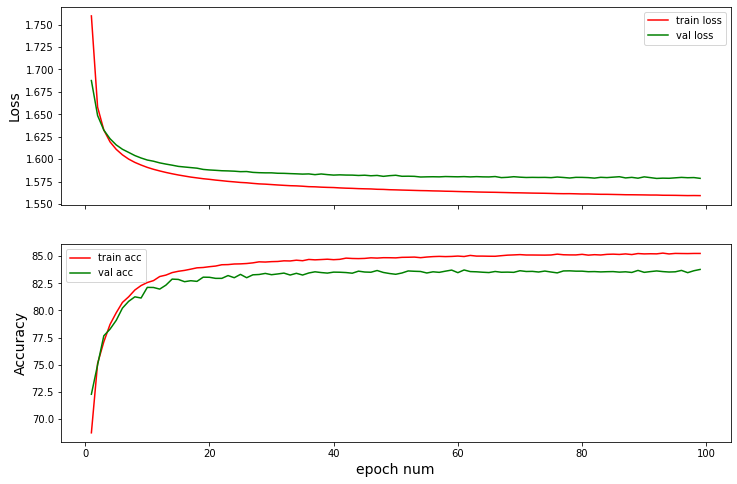

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
x = range(1, 100)
ax[0].plot(x, mean_train_loss, c='r', label='train loss')
ax[0].plot(x, mean_val_loss, c='green', label='val loss')
ax[0].legend()
ax[0].set_ylabel('Loss', fontsize=14)

ax[1].plot(x, mean_train_acc, c='r', label='train acc')
ax[1].plot(x, mean_val_acc, c='green', label='val acc')
ax[1].legend()

ax[1].set_xlabel('epoch num', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
plt.show()

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие модели были лучше и как вы думаете почему?

In [ ]:
def train_model(model, dataloader, optimizer, loss, epochs=11):
    mean_train_loss, mean_val_loss = [], []  # сюда будем складывать историю среднего лосса по батчам на трейне и val
    mean_train_acc, mean_val_acc = [], []  # то же для accuracy
    for epoch in range(1, epochs):
      train_loss_batch, train_acc_batch = [], []
      val_loss_batch, val_acc_batch = [], []
      
      for x_train, y_train in tqdm(dataloader[0]):          
          inputs, labels = x_train, y_train
          inputs, labels = inputs.to(device), labels.to(device)

          probs = model(inputs) # Получаем предсказание модели
          calc_loss = loss(probs, labels) # Считаем loss
          preds = torch.argmax(probs.cpu().data, dim=-1)
          calc_loss.backward() # Считаем градиенты
          optimizer.step() # Обновляем параметры модели
          acc = (preds == labels.cpu().data).sum().item() * 100 / labels.shape[0]
          # print(acc)
          # Печатаем статистику обучения
          train_loss_batch.append(calc_loss.item())
          train_acc_batch.append(acc)
          optimizer.zero_grad() # Зануляем градиенты

      mean_train_loss.append(np.mean(train_loss_batch))
      mean_train_acc.append(np.mean(train_acc_batch))
      print(epoch, '\n', 'Train:', {'loss': mean_train_loss[-1], 
                                    'accuracy': mean_train_acc[-1]}, sep='')
      
      with torch.no_grad():
        for x_val, y_val in tqdm(dataloader[1]):          
            inputs, labels = x_val, y_val # batch
            inputs, labels = inputs.to(device), labels.to(device)

            probs = model(inputs) # Получаем предсказание модели
            calc_loss = loss(probs, labels) # Считаем loss
            preds = torch.argmax(probs.cpu().data, dim=-1)
            acc = (preds == labels.cpu().data).sum().item() * 100 / labels.shape[0]
            # Печатаем статистику обучения
            val_loss_batch.append(calc_loss.item())
            val_acc_batch.append(acc)

        mean_val_loss.append(np.mean(val_loss_batch))
        mean_val_acc.append(np.mean(val_acc_batch))
        print('Eval:', {'loss': mean_val_loss[-1], 'accuracy': mean_val_acc[-1]})

    print('Обучение завершено') 
    return mean_train_loss, mean_train_acc, mean_val_loss, mean_val_acc

In [ ]:
class FirstModel(nn.Module):
    def __init__(self, dropout=0.3):
        super(FirstModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 16, 120)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.softmax(x, dim=-1)

model1 = FirstModel()

In [ ]:
model2 = nn.Sequential(
    nn.Flatten(), # превращаем картинку 28х28 в вектор длины 784
    nn.Linear(784, 512), # входной слой размером 784 нейронов с выходом в 128 нейронов
    nn.ReLU(), # функция активации релу
    nn.Linear(512, 256), # функция активации релу
    nn.ReLU(), # функция активации релу
    nn.Linear(256, 10), # функция активации релу
    nn.Softmax(dim=-1) # софтмакс для получения вероятностного распределения над метками класса
)

In [ ]:
# # third_model = torch.nn.ModuleDict({
# #     # your code here
# # })

# class ThirdModel(nn.Module):
#     def __init__(self, in_dim, hidden_dim):
#         super().__init__()
#         """
#         in_dim --- размерность слоев на входе (используется в nn.Conv2d)
#         hidden_dim --- скрытая размерность слоев (используется в nn.Conv2d)
#         """

#         # размерность на входе и на  выходе этого модуля должна быть одинаковой
#         # чтобы было возможно сложить результат работы этого слоя с его входным тензором
#         self.conv_block1 = nn.Sequential(
#             # [ bs, ch, w, h ]
#             nn.Conv2d(1, 16, kernel_size=3, padding=1), # [ bs, 16, w, h ]
#             nn.ReLU(),
#             nn.Conv2d(16, 8, kernel_size=3, padding=1), # [ bs, 8, w, h ]
#             nn.ReLU(),
#             nn.Conv2d(8, 1, kernel_size=3, padding=1), # [ bs, 1, w, h ]
#         )

#         self.flat = nn.Flatten(1), # [ bs, 3 * w * h ]
#         nn.Linear(3 * 28 * 28, 10), # [ bs, 10 ]
#     def forward(self, x):
#         out = self.model(x)
#         x = out + x
#         o

# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Sequential(
#                         nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
#                         nn.BatchNorm2d(out_channels),
#                         nn.ReLU())
#         self.conv2 = nn.Sequential(
#                         nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
#                         nn.BatchNorm2d(out_channels))
#         self.downsample = downsample
#         self.relu = nn.ReLU()
#         self.out_channels = out_channels
#         self.pool = nn.MaxPool2d(2, 2)
#         self.flat = nn.Flatten()
#         self.fc = nn.Linear(16 * 16, 10)
        
#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.conv2(out)
#         if self.downsample:
#             residual = self.downsample(x)
#         out += residual
#         out = self.pool(out)
#         out = self.flat(out)
#         out = self.relu(out)
#         return F.softmax(x, dim=-1)

# model3 = ResidualBlock(1, 1)

class Block(nn.Module):
    def __init__(self, a, b, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(
            a, b, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(b)
        self.conv2 = nn.Conv2d(b, b, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(b)

        self.f = nn.Sequential()
        if stride != 1 or a != b:
            self.f = nn.Sequential(
                nn.Conv2d(a, b, 1, stride=stride, bias=False),
                nn.BatchNorm2d(b)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.f(x)
        out = F.relu(out)
        return out

class Resnet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(Resnet, self).__init__()
        self.in_ = 64

        self.conv1 = nn.Conv2d(1, 64, 3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, 2, stride=1)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.linear = nn.Linear(128, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_, planes, stride))
            self.in_ = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, 3*4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


model3 = Resnet(Block)

In [ ]:
optimizer_rmsp = optim.RMSprop(params=model1.parameters(), lr=0.001)
optimizer_sgd = optim.SGD(params=model1.parameters(), lr=0.001, momentum=0.9)
model1.to(device)

FirstModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
train_loss1, train_acc1, val_loss1, val_acc1 = train_model(model1, (train_dataloader, eval_dataloader), optimizer_rmsp, loss)

100%|██████████| 469/469 [00:08<00:00, 55.16it/s]


1
Train:{'loss': 1.8039963194556328, 'accuracy': 66.03089463397299}


100%|██████████| 79/79 [00:01<00:00, 71.49it/s]


Eval: {'loss': 1.7197387806976898, 'accuracy': 74.37697784810126}


100%|██████████| 469/469 [00:06<00:00, 68.35it/s]


2
Train:{'loss': 1.7019634739930696, 'accuracy': 76.12717661691543}


100%|██████████| 79/79 [00:01<00:00, 70.16it/s]


Eval: {'loss': 1.6859570636024959, 'accuracy': 78.06566455696202}


100%|██████████| 469/469 [00:06<00:00, 68.72it/s]


3
Train:{'loss': 1.6676491801418476, 'accuracy': 79.55979033404407}


100%|██████████| 79/79 [00:01<00:00, 72.72it/s]


Eval: {'loss': 1.6753126367737976, 'accuracy': 78.85680379746836}


100%|██████████| 469/469 [00:06<00:00, 67.89it/s]


4
Train:{'loss': 1.650134135919339, 'accuracy': 81.25832889125799}


100%|██████████| 79/79 [00:01<00:00, 71.27it/s]


Eval: {'loss': 1.6587599591363835, 'accuracy': 80.13251582278481}


100%|██████████| 469/469 [00:07<00:00, 60.56it/s]


5
Train:{'loss': 1.636024043504109, 'accuracy': 82.6486984719261}


100%|██████████| 79/79 [00:01<00:00, 71.55it/s]


Eval: {'loss': 1.6385662027552157, 'accuracy': 82.41693037974683}


100%|██████████| 469/469 [00:07<00:00, 65.96it/s]


6
Train:{'loss': 1.6259978023419248, 'accuracy': 83.6065209665956}


100%|██████████| 79/79 [00:01<00:00, 72.11it/s]


Eval: {'loss': 1.627319409877439, 'accuracy': 83.4256329113924}


100%|██████████| 469/469 [00:07<00:00, 60.77it/s]


7
Train:{'loss': 1.6180886142035282, 'accuracy': 84.37999733475479}


100%|██████████| 79/79 [00:01<00:00, 71.49it/s]


Eval: {'loss': 1.623564851434925, 'accuracy': 83.82120253164557}


100%|██████████| 469/469 [00:06<00:00, 68.27it/s]


8
Train:{'loss': 1.6116429572420587, 'accuracy': 85.07240582800284}


100%|██████████| 79/79 [00:01<00:00, 71.80it/s]


Eval: {'loss': 1.6184553737881817, 'accuracy': 84.40466772151899}


100%|██████████| 469/469 [00:07<00:00, 62.07it/s]


9
Train:{'loss': 1.606662714659278, 'accuracy': 85.48052149964464}


100%|██████████| 79/79 [00:01<00:00, 70.04it/s]


Eval: {'loss': 1.611117375047901, 'accuracy': 85.09691455696202}


100%|██████████| 469/469 [00:07<00:00, 66.42it/s]


10
Train:{'loss': 1.6032825967650424, 'accuracy': 85.80146144278606}


100%|██████████| 79/79 [00:01<00:00, 69.72it/s]

Eval: {'loss': 1.6125455853305286, 'accuracy': 84.9189082278481}
Обучение завершено


In [ ]:
for layer in model1.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [ ]:
train_loss2, train_acc2, val_loss2, val_acc2 = train_model(model1, (train_dataloader, eval_dataloader), optimizer_sgd, loss)

100%|██████████| 469/469 [00:07<00:00, 66.13it/s]


1
Train:{'loss': 2.3026504847032427, 'accuracy': 9.226745735607675}


100%|██████████| 79/79 [00:01<00:00, 68.54it/s]


Eval: {'loss': 2.302591293672972, 'accuracy': 9.216772151898734}


100%|██████████| 469/469 [00:06<00:00, 68.20it/s]


2
Train:{'loss': 2.302575754966817, 'accuracy': 9.367781627576402}


100%|██████████| 79/79 [00:01<00:00, 68.39it/s]


Eval: {'loss': 2.30249610128282, 'accuracy': 9.26621835443038}


100%|██████████| 469/469 [00:06<00:00, 69.05it/s]


3
Train:{'loss': 2.302478753173275, 'accuracy': 9.540467306325516}


100%|██████████| 79/79 [00:01<00:00, 70.46it/s]


Eval: {'loss': 2.3024011805087707, 'accuracy': 9.731012658227849}


100%|██████████| 469/469 [00:06<00:00, 68.92it/s]


4
Train:{'loss': 2.302394522786903, 'accuracy': 9.664290156361051}


100%|██████████| 79/79 [00:01<00:00, 71.63it/s]


Eval: {'loss': 2.3023241350922405, 'accuracy': 10.195806962025317}


100%|██████████| 469/469 [00:06<00:00, 69.23it/s]


5
Train:{'loss': 2.3022916525411707, 'accuracy': 9.98134328358209}


100%|██████████| 79/79 [00:01<00:00, 70.43it/s]


Eval: {'loss': 2.30227808710895, 'accuracy': 9.879351265822784}


100%|██████████| 469/469 [00:06<00:00, 69.03it/s]


6
Train:{'loss': 2.3022113934254596, 'accuracy': 10.165134150675197}


100%|██████████| 79/79 [00:01<00:00, 68.25it/s]


Eval: {'loss': 2.3021327091168753, 'accuracy': 10.077136075949367}


100%|██████████| 469/469 [00:06<00:00, 68.53it/s]


7
Train:{'loss': 2.302072481814224, 'accuracy': 10.451092750533048}


100%|██████████| 79/79 [00:01<00:00, 71.33it/s]


Eval: {'loss': 2.3020323952542077, 'accuracy': 10.621044303797468}


100%|██████████| 469/469 [00:06<00:00, 68.08it/s]


8
Train:{'loss': 2.301938565809335, 'accuracy': 10.683746446339729}


100%|██████████| 79/79 [00:01<00:00, 69.99it/s]


Eval: {'loss': 2.3018611533732356, 'accuracy': 10.660601265822784}


100%|██████████| 469/469 [00:06<00:00, 68.59it/s]


9
Train:{'loss': 2.301770671344261, 'accuracy': 11.050772921108742}


100%|██████████| 79/79 [00:01<00:00, 71.72it/s]


Eval: {'loss': 2.3016416754903672, 'accuracy': 11.075949367088608}


100%|██████████| 469/469 [00:06<00:00, 68.17it/s]


10
Train:{'loss': 2.3015472223001248, 'accuracy': 11.56216684434968}


100%|██████████| 79/79 [00:01<00:00, 70.04it/s]

Eval: {'loss': 2.3014850344838975, 'accuracy': 11.352848101265822}
Обучение завершено


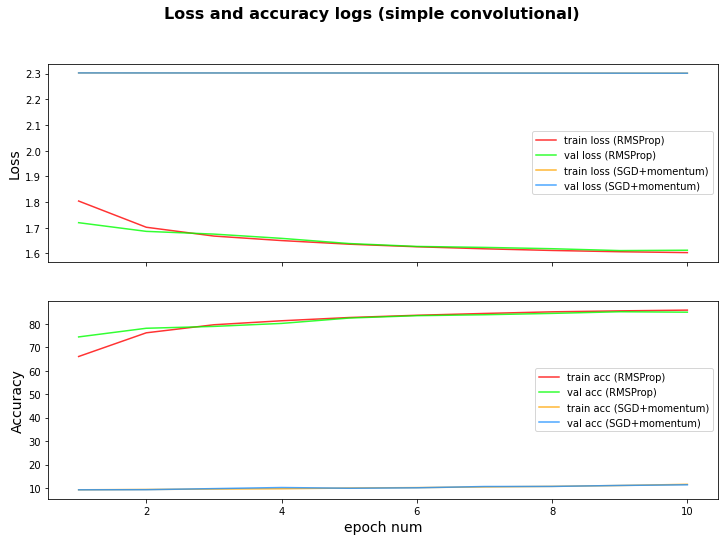

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
x = range(1, 11)
ax[0].plot(x, train_loss1, c='r', alpha=0.8, label='train loss (RMSProp)')
ax[0].plot(x, val_loss1, c='lime', alpha=0.8, label='val loss (RMSProp)')

ax[0].plot(x, train_loss2, c='orange', alpha=0.8, label='train loss (SGD+momentum)')
ax[0].plot(x, val_loss2, c='dodgerblue', alpha=0.8, label='val loss (SGD+momentum)')
ax[0].legend()
ax[0].set_ylabel('Loss', fontsize=14)

ax[1].plot(x, train_acc1, c='r', alpha=0.8, label='train acc (RMSProp)')
ax[1].plot(x, val_acc1, c='lime', alpha=0.8, label='val acc (RMSProp)')

ax[1].plot(x, train_acc2, c='orange', alpha=0.8, label='train acc (SGD+momentum)')
ax[1].plot(x, val_acc2, c='dodgerblue', alpha=0.8, label='val acc (SGD+momentum)')
ax[1].legend()

ax[1].set_xlabel('epoch num', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
plt.suptitle('Loss and accuracy logs (simple convolutional)', fontsize=16, weight='bold')
plt.show()

In [ ]:
optimizer_rmsp2 = optim.RMSprop(params=model2.parameters(), lr=0.001)
optimizer_sgd2 = optim.SGD(params=model2.parameters(), lr=0.001, momentum=0.9)
model2.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=True)
  (6): Softmax(dim=-1)
)

In [ ]:
train_loss3, train_acc3, val_loss3, val_acc3 = train_model(model2, (train_dataloader, eval_dataloader), optimizer_rmsp2, loss)

100%|██████████| 469/469 [00:06<00:00, 74.45it/s]


1
Train:{'loss': 1.6924927379530885, 'accuracy': 77.07889125799574}


100%|██████████| 79/79 [00:01<00:00, 73.51it/s]


Eval: {'loss': 1.6355414405653748, 'accuracy': 82.7432753164557}


100%|██████████| 469/469 [00:06<00:00, 73.60it/s]


2
Train:{'loss': 1.6231235288607795, 'accuracy': 83.87193496801706}


100%|██████████| 79/79 [00:01<00:00, 72.06it/s]


Eval: {'loss': 1.6225166366070132, 'accuracy': 83.86075949367088}


100%|██████████| 469/469 [00:06<00:00, 74.00it/s]


3
Train:{'loss': 1.609730624186713, 'accuracy': 85.13015280739161}


100%|██████████| 79/79 [00:01<00:00, 73.10it/s]


Eval: {'loss': 1.638630492777764, 'accuracy': 82.2685917721519}


100%|██████████| 469/469 [00:06<00:00, 73.88it/s]


4
Train:{'loss': 1.6021758513664133, 'accuracy': 85.90585021321962}


100%|██████████| 79/79 [00:01<00:00, 73.33it/s]


Eval: {'loss': 1.6150721839711637, 'accuracy': 84.65189873417721}


100%|██████████| 469/469 [00:06<00:00, 73.88it/s]


5
Train:{'loss': 1.5943738849940838, 'accuracy': 86.65600568585643}


100%|██████████| 79/79 [00:01<00:00, 74.42it/s]


Eval: {'loss': 1.6010146654104884, 'accuracy': 85.97705696202532}


100%|██████████| 469/469 [00:06<00:00, 73.75it/s]


6
Train:{'loss': 1.5899089648525344, 'accuracy': 87.0985474413646}


100%|██████████| 79/79 [00:01<00:00, 72.53it/s]


Eval: {'loss': 1.5983842430235464, 'accuracy': 86.20450949367088}


100%|██████████| 469/469 [00:06<00:00, 74.50it/s]


7
Train:{'loss': 1.5868856723883005, 'accuracy': 87.41948738450604}


100%|██████████| 79/79 [00:01<00:00, 72.46it/s]


Eval: {'loss': 1.5948672792579555, 'accuracy': 86.67919303797468}


100%|██████████| 469/469 [00:06<00:00, 74.37it/s]


8
Train:{'loss': 1.584306340481935, 'accuracy': 87.69378553660269}


100%|██████████| 79/79 [00:01<00:00, 73.02it/s]


Eval: {'loss': 1.6014654274228253, 'accuracy': 85.98694620253164}


100%|██████████| 469/469 [00:06<00:00, 73.85it/s]


9
Train:{'loss': 1.5829045820846233, 'accuracy': 87.78096126510306}


100%|██████████| 79/79 [00:01<00:00, 73.07it/s]


Eval: {'loss': 1.598971941803075, 'accuracy': 86.1056170886076}


100%|██████████| 469/469 [00:06<00:00, 72.73it/s]


10
Train:{'loss': 1.580458714763747, 'accuracy': 88.0719171997157}


100%|██████████| 79/79 [00:01<00:00, 71.42it/s]

Eval: {'loss': 1.5926978588104248, 'accuracy': 86.79786392405063}
Обучение завершено


In [ ]:
for layer in model2.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [ ]:
train_loss4, train_acc4, val_loss4, val_acc4 = train_model(model2, (train_dataloader, eval_dataloader), optimizer_sgd2, loss)

100%|██████████| 469/469 [00:06<00:00, 72.74it/s]


1
Train:{'loss': 2.299423671734613, 'accuracy': 24.725701847903338}


100%|██████████| 79/79 [00:01<00:00, 72.24it/s]


Eval: {'loss': 2.2962648808201656, 'accuracy': 28.035996835443036}


100%|██████████| 469/469 [00:06<00:00, 75.05it/s]


2
Train:{'loss': 2.2920891679426245, 'accuracy': 31.146721748400854}


100%|██████████| 79/79 [00:01<00:00, 72.40it/s]


Eval: {'loss': 2.287204428564144, 'accuracy': 33.3564082278481}


100%|██████████| 469/469 [00:06<00:00, 73.25it/s]


3
Train:{'loss': 2.278977671665932, 'accuracy': 33.84861407249467}


100%|██████████| 79/79 [00:01<00:00, 73.15it/s]


Eval: {'loss': 2.2683413722847083, 'accuracy': 33.43552215189873}


100%|██████████| 469/469 [00:06<00:00, 75.77it/s]


4
Train:{'loss': 2.2449521840508306, 'accuracy': 31.93185856432125}


100%|██████████| 79/79 [00:01<00:00, 73.10it/s]


Eval: {'loss': 2.2073171440559096, 'accuracy': 29.667721518987342}


100%|██████████| 469/469 [00:06<00:00, 75.14it/s]


5
Train:{'loss': 2.1569629645805115, 'accuracy': 29.424307036247335}


100%|██████████| 79/79 [00:01<00:00, 72.71it/s]


Eval: {'loss': 2.1112797441361826, 'accuracy': 35.57159810126582}


100%|██████████| 469/469 [00:06<00:00, 74.60it/s]


6
Train:{'loss': 2.052698053276615, 'accuracy': 50.89230188343994}


100%|██████████| 79/79 [00:01<00:00, 72.03it/s]


Eval: {'loss': 1.9945778424226785, 'accuracy': 57.23892405063291}


100%|██████████| 469/469 [00:06<00:00, 74.95it/s]


7
Train:{'loss': 1.9491229519915225, 'accuracy': 60.80590351812367}


100%|██████████| 79/79 [00:01<00:00, 73.19it/s]


Eval: {'loss': 1.9163028967531421, 'accuracy': 61.73852848101266}


100%|██████████| 469/469 [00:06<00:00, 74.79it/s]


8
Train:{'loss': 1.894230926977292, 'accuracy': 62.22125977256574}


100%|██████████| 79/79 [00:01<00:00, 71.89it/s]


Eval: {'loss': 1.880359571191329, 'accuracy': 62.21321202531646}


100%|██████████| 469/469 [00:06<00:00, 74.54it/s]


9
Train:{'loss': 1.8684934057406526, 'accuracy': 62.520544598436395}


100%|██████████| 79/79 [00:01<00:00, 72.99it/s]


Eval: {'loss': 1.8620044249522536, 'accuracy': 62.59889240506329}


100%|██████████| 469/469 [00:06<00:00, 75.65it/s]


10
Train:{'loss': 1.8507490277544523, 'accuracy': 63.35398898365316}


100%|██████████| 79/79 [00:01<00:00, 73.81it/s]

Eval: {'loss': 1.8413878271851358, 'accuracy': 65.10087025316456}
Обучение завершено


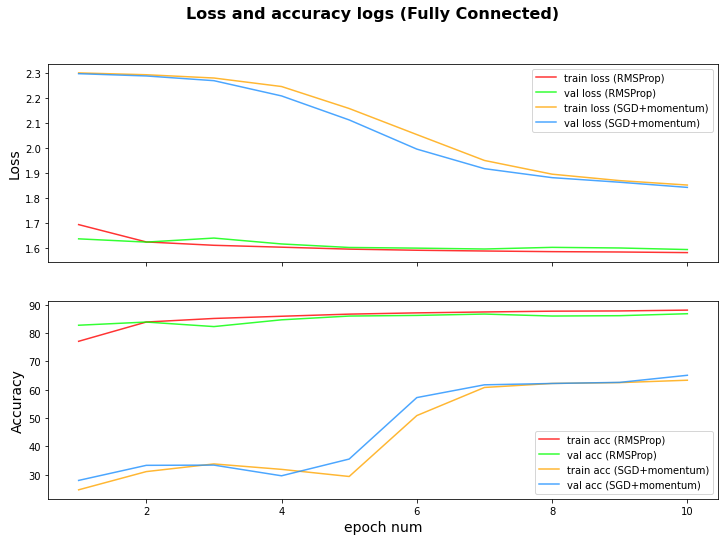

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(x, train_loss3, c='r', alpha=0.8, label='train loss (RMSProp)')
ax[0].plot(x, val_loss3, c='lime', alpha=0.8, label='val loss (RMSProp)')

ax[0].plot(x, train_loss4, c='orange', alpha=0.8, label='train loss (SGD+momentum)')
ax[0].plot(x, val_loss4, c='dodgerblue', alpha=0.8, label='val loss (SGD+momentum)')
ax[0].legend()
ax[0].set_ylabel('Loss', fontsize=14)

ax[1].plot(x, train_acc3, c='r', alpha=0.8, label='train acc (RMSProp)')
ax[1].plot(x, val_acc3, c='lime', alpha=0.8, label='val acc (RMSProp)')

ax[1].plot(x, train_acc4, c='orange', alpha=0.8, label='train acc (SGD+momentum)')
ax[1].plot(x, val_acc4, c='dodgerblue', alpha=0.8, label='val acc (SGD+momentum)')
ax[1].legend()

ax[1].set_xlabel('epoch num', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
plt.suptitle('Loss and accuracy logs (Fully Connected)', fontsize=16, weight='bold')
plt.show()

In [ ]:
optimizer_rmsp3 = optim.RMSprop(params=model3.parameters(), lr=0.001)
optimizer_sgd3 = optim.SGD(params=model3.parameters(), lr=0.001, momentum=0.9)
model3.to(device)

Resnet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (f): Sequential()
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
train_loss5, train_acc5, val_loss5, val_acc5 = train_model(model3, (train_dataloader, eval_dataloader), optimizer_rmsp3, loss)

100%|██████████| 469/469 [00:30<00:00, 15.57it/s]


1
Train:{'loss': 0.4409257690789603, 'accuracy': 84.05350479744136}


100%|██████████| 79/79 [00:01<00:00, 45.55it/s]


Eval: {'loss': 0.35656445124481295, 'accuracy': 87.25276898734177}


100%|██████████| 469/469 [00:28<00:00, 16.18it/s]


2
Train:{'loss': 0.2814317955327695, 'accuracy': 89.88095238095238}


100%|██████████| 79/79 [00:01<00:00, 44.37it/s]


Eval: {'loss': 0.2974036550974544, 'accuracy': 89.35917721518987}


100%|██████████| 469/469 [00:29<00:00, 15.66it/s]


3
Train:{'loss': 0.23354611277326084, 'accuracy': 91.49009417199716}


100%|██████████| 79/79 [00:02<00:00, 37.18it/s]


Eval: {'loss': 0.2584350645730767, 'accuracy': 90.75356012658227}


100%|██████████| 469/469 [00:29<00:00, 15.66it/s]


4
Train:{'loss': 0.20366006582848298, 'accuracy': 92.54675284292823}


100%|██████████| 79/79 [00:01<00:00, 43.93it/s]


Eval: {'loss': 0.2539919407307347, 'accuracy': 90.98101265822785}


100%|██████████| 469/469 [00:30<00:00, 15.41it/s]


5
Train:{'loss': 0.1827950712237785, 'accuracy': 93.38686034115139}


100%|██████████| 79/79 [00:01<00:00, 43.98it/s]


Eval: {'loss': 0.25256802066217493, 'accuracy': 90.81289556962025}


100%|██████████| 469/469 [00:30<00:00, 15.28it/s]


6
Train:{'loss': 0.1649818633204457, 'accuracy': 94.02207711442786}


100%|██████████| 79/79 [00:01<00:00, 44.08it/s]


Eval: {'loss': 0.23768920234487026, 'accuracy': 91.6435917721519}


100%|██████████| 469/469 [00:30<00:00, 15.35it/s]


7
Train:{'loss': 0.14954667234185662, 'accuracy': 94.5373578535892}


100%|██████████| 79/79 [00:01<00:00, 44.39it/s]


Eval: {'loss': 0.22053704938933819, 'accuracy': 91.9501582278481}


100%|██████████| 469/469 [00:30<00:00, 15.45it/s]


8
Train:{'loss': 0.13289280209555301, 'accuracy': 95.19200870646766}


100%|██████████| 79/79 [00:01<00:00, 44.70it/s]


Eval: {'loss': 0.22094668976113765, 'accuracy': 92.30617088607595}


100%|██████████| 469/469 [00:30<00:00, 15.47it/s]


9
Train:{'loss': 0.12076901198466068, 'accuracy': 95.63232942430703}


100%|██████████| 79/79 [00:01<00:00, 43.86it/s]


Eval: {'loss': 0.21892867859783052, 'accuracy': 92.58306962025317}


100%|██████████| 469/469 [00:30<00:00, 15.45it/s]


10
Train:{'loss': 0.10514819390102745, 'accuracy': 96.21368603411514}


100%|██████████| 79/79 [00:01<00:00, 44.60it/s]

Eval: {'loss': 0.22008739015724085, 'accuracy': 92.79074367088607}
Обучение завершено


In [ ]:
for layer in model3.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [ ]:
train_loss6, train_acc6, val_loss6, val_acc6 = train_model(model3, (train_dataloader, eval_dataloader), optimizer_sgd3, loss)

 43%|████▎     | 203/469 [00:13<00:17, 15.47it/s]


KeyboardInterrupt: ignored

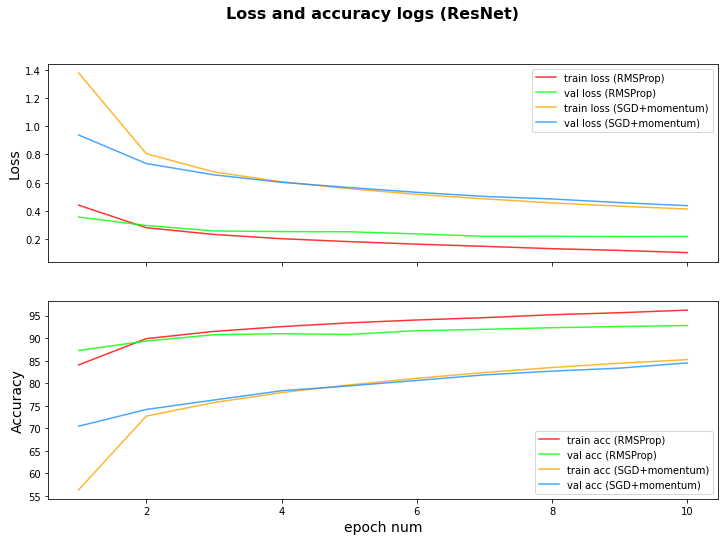

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(x, train_loss5, c='r', alpha=0.8, label='train loss (RMSProp)')
ax[0].plot(x, val_loss5, c='lime', alpha=0.8, label='val loss (RMSProp)')
ax[0].legend()
ax[0].set_ylabel('Loss', fontsize=14)

ax[0].plot(x, train_loss6, c='orange', alpha=0.8, label='train loss (SGD+momentum)')
ax[0].plot(x, val_loss6, c='dodgerblue', alpha=0.8, label='val loss (SGD+momentum)')
ax[0].legend()
ax[0].set_ylabel('Loss', fontsize=14)

ax[1].plot(x, train_acc5, c='r', alpha=0.8, label='train acc (RMSProp)')
ax[1].plot(x, val_acc5, c='lime', alpha=0.8, label='val acc (RMSProp)')
ax[1].legend()

ax[1].plot(x, train_acc6, c='orange', alpha=0.8, label='train acc (SGD+momentum)')
ax[1].plot(x, val_acc6, c='dodgerblue', alpha=0.8, label='val acc (SGD+momentum)')
ax[1].legend()

ax[1].set_xlabel('epoch num', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
plt.suptitle('Loss and accuracy logs (ResNet)', fontsize=16, weight='bold')
plt.show()

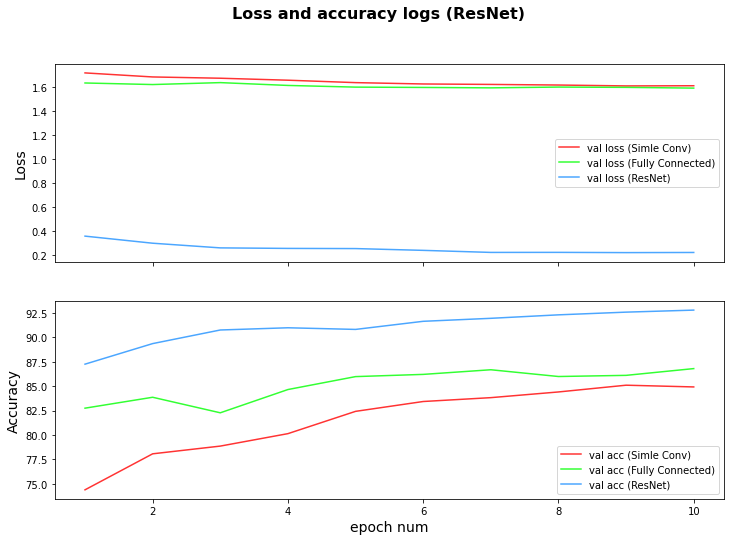

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(x, val_loss1, c='r', alpha=0.8, label='val loss (Simle Conv)')
ax[0].plot(x, val_loss3, c='lime', alpha=0.8, label='val loss (Fully Connected)')
ax[0].plot(x, val_loss5, c='dodgerblue', alpha=0.8, label='val loss (ResNet)')
ax[0].legend()
ax[0].set_ylabel('Loss', fontsize=14)

ax[1].plot(x, val_acc1, c='r', alpha=0.8, label='val acc (Simle Conv)')
ax[1].plot(x, val_acc3, c='lime', alpha=0.8, label='val acc (Fully Connected)')
ax[1].plot(x, val_acc5, c='dodgerblue', alpha=0.8, label='val acc (ResNet)')
ax[1].legend()

ax[1].set_xlabel('epoch num', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
plt.suptitle('Loss and accuracy logs (ResNet)', fontsize=16, weight='bold')
plt.show()